In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib
import importance_sample_lib as imp_lib
import common_utils 

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=3, max_galaxies=3, num_bands=5, num_images=50, 
                        brightness = 5000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

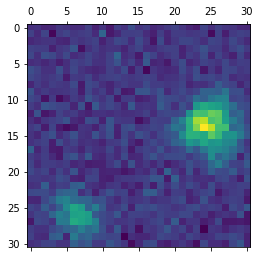

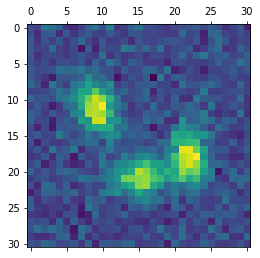

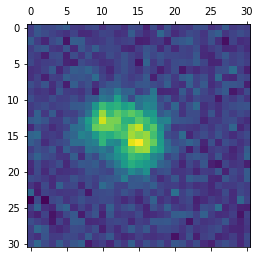

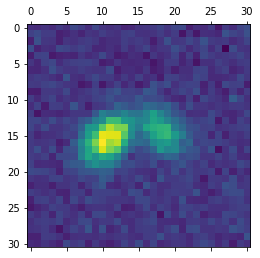

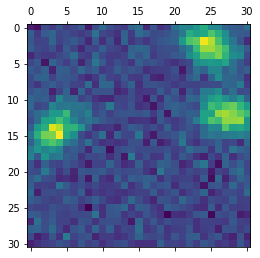

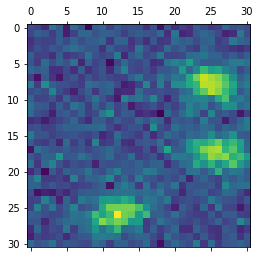

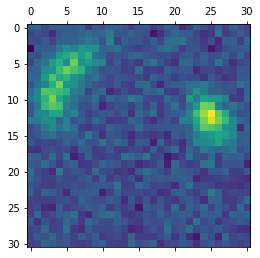

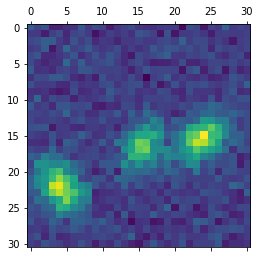

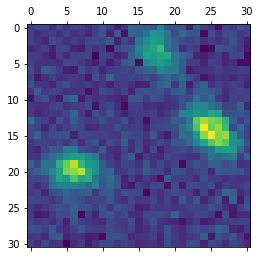

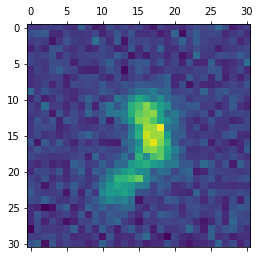

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
imp_weights = imp_lib.get_importance_weights(images_batch1 - backgrounds_batch1, attn_offset=4, prob_off=0)

(array([345.,  34.,  18.,  17.,  10.,  11.,   6.,   8.,  10.,   5.,   4.,
          2.,   9.,   6.,   3.,   4.,   3.,   8.,   6.,   5.,   4.,   1.,
          1.,   1.,   2.,   2.,   1.,   1.,   2.,   1.]),
 array([0.        , 0.00056587, 0.00113174, 0.00169761, 0.00226347,
        0.00282934, 0.00339521, 0.00396108, 0.00452695, 0.00509282,
        0.00565868, 0.00622455, 0.00679042, 0.00735629, 0.00792216,
        0.00848803, 0.0090539 , 0.00961976, 0.01018563, 0.0107515 ,
        0.01131737, 0.01188324, 0.01244911, 0.01301498, 0.01358084,
        0.01414671, 0.01471258, 0.01527845, 0.01584432, 0.01641019,
        0.01697605]),
 <a list of 30 Patch objects>)

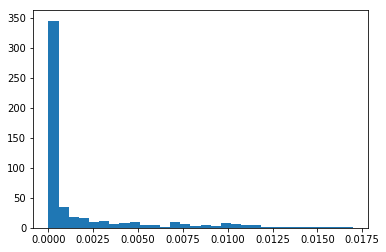

In [8]:
vec = imp_weights[2, :]
plt.hist(vec, bins = 30)

In [9]:
imp_weights

tensor(1.00000e-02 *
       [[ 0.0040,  0.0253,  0.0425,  ...,  0.0000,  0.0126,  0.0000],
        [ 0.0000,  0.0221,  0.0152,  ...,  0.0140,  0.0183,  0.0000],
        [ 0.0075,  0.0274,  0.0142,  ...,  0.0114,  0.0000,  0.0000],
        ...,
        [ 0.0103,  0.0168,  0.0136,  ...,  0.0069,  0.0222,  0.0000],
        [ 0.0125,  0.0087,  0.0123,  ...,  0.0152,  0.0065,  0.0000],
        [ 0.0108,  0.0053,  0.0157,  ...,  0.0248,  0.0115,  0.0000]])

In [10]:
torch.min(imp_weights)

tensor(0.)

# The VAE

In [11]:
one_galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [12]:
# state_dict = torch.load("./galaxy_vae.dat", map_location='cpu')
# # state_dict = torch.load("../galaxy_results/test_epoch80.dat", map_location='cpu')

# galaxy_vae.load_state_dict(state_dict, strict=False)

one_galaxy_vae.eval(); 

In [13]:
galaxy_vae = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=one_galaxy_vae)

In [14]:
pixel_probs = galaxy_vae.get_pixel_probs(images_batch1, backgrounds_batch1)

In [15]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [17]:
recon_mean, recon_var, is_on, kl_z = galaxy_vae.sample_conditional_a(
                                            resid_image = images_batch1 - backgrounds_batch1, 
                                            var_so_far = backgrounds_batch1, 
                                            pixel_1d = map_pixel_loc)

In [18]:
map_pixel_loc

tensor([ 252,  215,  238,  286,  277,  363,  247,  298,  252,  292])

In [19]:
is_on

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

(array([  1.,   0.,   8.,  18.,  51., 435.,   8.,   2.,   5.,   2.]),
 array([1.18745244e-16, 3.61117395e-04, 7.22234789e-04, 1.08335218e-03,
        1.44446958e-03, 1.80558697e-03, 2.16670437e-03, 2.52782176e-03,
        2.88893916e-03, 3.25005655e-03, 3.61117395e-03]),
 <a list of 10 Patch objects>)

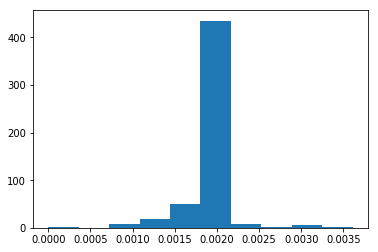

In [20]:
plt.hist(pixel_probs[0, :].detach())

In [21]:
recon_mean.sum()

tensor(863.6387)

In [22]:
recon_var.sum()

tensor(5157.1582)

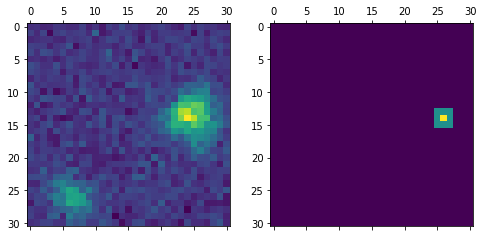

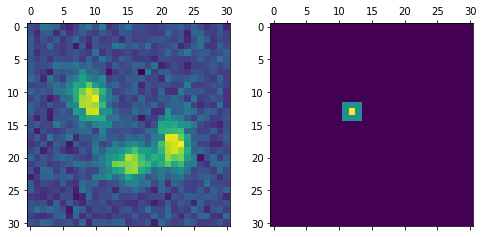

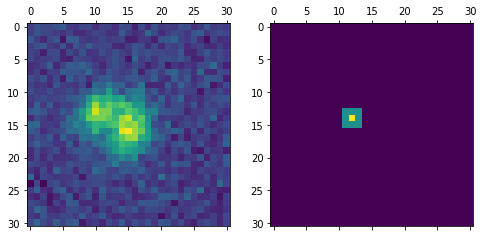

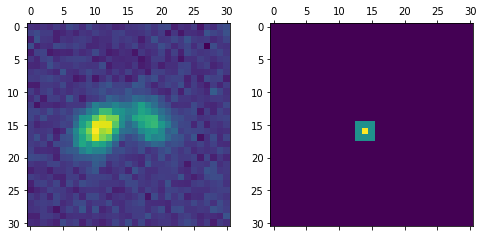

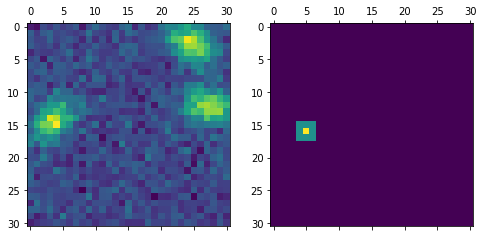

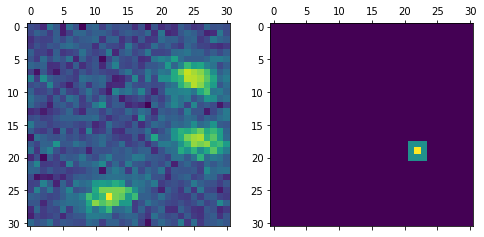

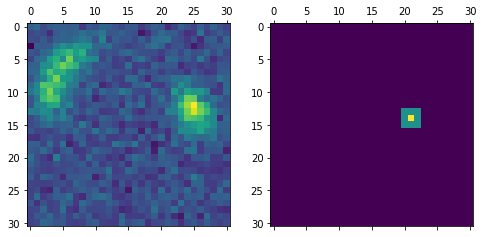

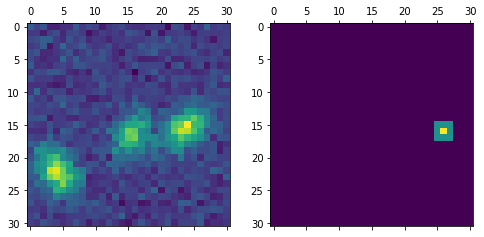

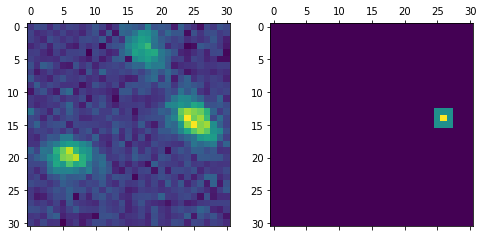

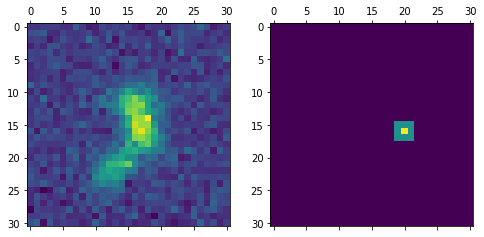

In [23]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())


# Experimenting with new importance sampling functions

In [24]:
# function to normalize image
attn_offset = galaxy_vae.attn_offset
# normalized_image = imp_lib.crop_and_normalize_image(images_batch1, attn_offset)

In [25]:
# normalized_image.sum(dim = 1).sum(dim = 1) - 1

In [26]:
# append probability of being off
prob_off = pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1, attn_offset, prob_off)

In [27]:
np.max(np.abs(importance_weights.numpy().sum(1) - 1.0))

4.7683716e-07

In [28]:
print(np.abs(importance_weights.numpy().sum(1) - 1.0))

[0.0000000e+00 4.7683716e-07 1.1920929e-07 2.3841858e-07 2.3841858e-07
 1.1920929e-07 1.1920929e-07 2.9802322e-07 5.9604645e-08 3.5762787e-07]


In [29]:
assert np.max(np.abs(importance_weights[:, -1].numpy() - prob_off.numpy().squeeze())) < 1e-16
assert np.max(np.abs(importance_weights.numpy().sum(1) - 1.0)) < 1e-6

In [30]:
# visually check importance weights: 

In [31]:
prob_off = torch.zeros((images_batch1.shape[0], 1)) # pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1 - backgrounds_batch1, attn_offset, prob_off)

In [32]:
which_n = 1
image_sampled = torch.zeros((side_len, side_len))
for i in range(10000): 
    z_sample = common_utils.sample_class_weights(importance_weights)
    pixel_2d = galaxy_vae.one_galaxy_vae.pixel_1d_to_2d(z_sample)
    image_sampled[pixel_2d[which_n, 0], pixel_2d[which_n, 1]] += 1

(array([360.,  54.,  40.,  27.,  14.,  12.,   9.,   7.,   3.,   4.]),
 array([0.        , 0.00151011, 0.00302022, 0.00453033, 0.00604044,
        0.00755055, 0.00906066, 0.01057078, 0.01208089, 0.013591  ,
        0.01510111]),
 <a list of 10 Patch objects>)

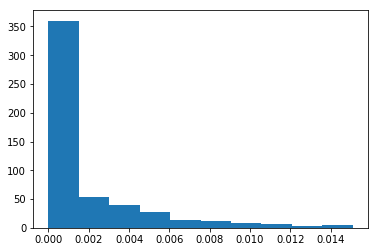

In [33]:
plt.hist(importance_weights[which_n, :])

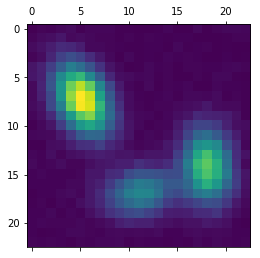

In [34]:
imp_weights_grid = importance_weights[:, 0:-1].view(images_batch1.shape[0], 23, 23)
plt.matshow(imp_weights_grid.detach()[which_n, :, :])

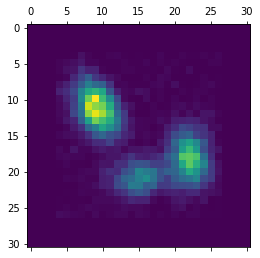

In [35]:
plt.matshow(image_sampled)

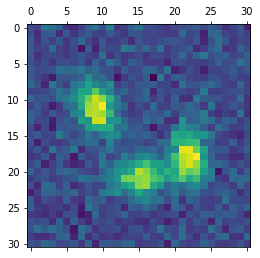

In [36]:
plt.matshow(images_batch1[which_n, 0, :, :])

In [37]:
# check optimizer goes through

In [38]:
optimizer = optim.Adam(galaxy_vae.parameters(), lr=0.01, weight_decay=1e-6)
optimizer.zero_grad()

In [39]:
pm_loss, neg_elbo, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_vae, images_batch1, backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True,
                                    max_detections = 2)

In [40]:
# check params
all_params = torch.zeros(1)

for f in galaxy_vae.parameters():
    params = f.view(-1)
    all_params = torch.cat([params, all_params])

In [41]:
pm_loss

tensor(-6.2072e+06)

In [42]:
pm_loss.backward()

In [43]:
optimizer.step()

In [44]:
_, neg_elbo2, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_vae, images_batch1, backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True,
                                    max_detections = 2)

In [45]:
neg_elbo2

tensor(1.00000e+05 *
       3.1771)

In [46]:
# check params
all_params2 = torch.zeros(1)

for f in galaxy_vae.parameters():
    params = f.view(-1)
    all_params2 = torch.cat([params, all_params2])

In [47]:
torch.max(all_params2 - all_params)

tensor(1.00000e-02 *
       1.0000)

(array([1.086030e+06, 1.160000e+03, 5.420000e+02, 6.590000e+02,
        1.147180e+05, 1.292380e+05, 7.940000e+02, 4.640000e+02,
        1.015000e+03, 1.063901e+06]),
 array([-0.01000001, -0.008     , -0.006     , -0.004     , -0.002     ,
         0.        ,  0.002     ,  0.004     ,  0.006     ,  0.008     ,
         0.01000001]),
 <a list of 10 Patch objects>)

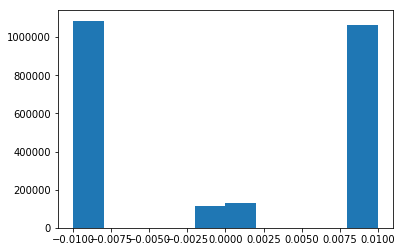

In [48]:
plt.hist((all_params2 - all_params).detach())

In [49]:
# Check train module

In [50]:
# train_module(vae, train_loader, test_loader, epochs,
#                         use_baseline = True,
#                         use_importance_sample = True,
#                         lr = 1e-4, weight_decay = 1e-6,
#                         save_every = 10,
#                         filename = './galaxy_vae_params',
#                         seed = 245345)

In [ ]:
imp_lib.train_module(galaxy_vae, train_loader, test_loader, 
                        epochs = 12, save_every = 2, 
                        use_baseline = True, 
                        use_importance_sample = True, 
                        max_detections = 2, 
                        lr = 1e-4, weight_decay = 1e-6,
                        filename = './test',
                        seed = 245345)

init batch loss: 298493 
  * init test loss: 362258
[1] loss: 303025  	[1.0 seconds]
[2] loss: 246903  	[1.2 seconds]
  * test loss: 234281
writing the network's parameters to ./test_epoch2.dat


In [ ]:
# check we can load it back

galaxy_vae_reload = celeste_net.OneGalaxyVAE(side_len)
state_dict = torch.load("./test_epoch10.dat", map_location='cpu')
galaxy_vae_reload.load_state_dict(state_dict, strict=False)

galaxy_vae_reload.eval(); 

In [ ]:
galaxy_vae_reload

In [ ]:
np.load('./test_test_losses_array.npy')